# Voltage clamp trace and efel

This notebook explains how to use traces from voltage clamp in efel. First, you need to load your modules and your trace data. Here, we will use experimental data from Channelpedia: https://channelpedia.epfl.ch/expdata/details/32500

    Ranjan R, Logette E, Marani M, Herzog M, Tache V, Scantamburlo E, Buchillier V and Markram H (2019) A Kinetic Map of the Homomeric Voltage-Gated Potassium Channel (Kv) Family. Front. Cell. Neurosci. 13:358. doi: 10.3389/fncel.2019.00358

    Blue Brain Project Portal (https://portal.bluebrain.epfl.ch) and Channelpedia (https://channelpedia.epfl.ch)

In [1]:
import h5py
import numpy as np

from matplotlib import pyplot as plt

import efel

In [2]:
data_path = "rCell32500.nwb"

data = {}
with h5py.File(data_path, "r") as content:
    reps = content["acquisition"]["timeseries"]["Activation"]["repetitions"]
    for rep_name, rep in reps.items():
        data[rep_name] = {
            "dt": np.array(rep["x_interval"], dtype="float32"),
            "current": np.array(rep["data"], dtype="float32"),
        }

Now we will turn this data into the traces list expected by eFel. For this example, we will only use the 1st repetition. You can change the repetition by renaming the rep_name variable into 'repetition2' or 'repetition3'. Notice that we have to give the time in ms. The trick here to use the eFel features is to give the current recording to the "V" key in the trace dict. eFel will treat the current trace as if it were a voltage trace.

In [13]:
traces = []
rep_name = "repetition1"
for idx in range(len(data[rep_name]["dt"])):
    trace = {}
    i = data[rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[rep_name]["dt"][idx]
    # efel expects ms: s -> ms
    t = t * 1000.0
    trace["T"] = t
    trace["V"] = i  # trick: input current as if it was voltage
    trace["stim_start"] = [99]
    trace["stim_end"] = [600]
    traces.append(trace)

We can plot the traces to see how they look:

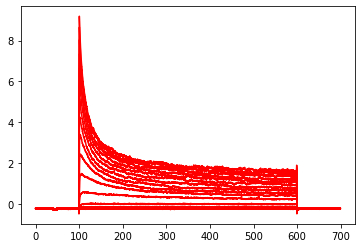

In [14]:
for t in traces:
    plt.plot(t["T"], t["V"], c="red")

We can now extract the desired features from eFel. Even if there is 'voltage' in the feature names, since we gave the current trace instead of the voltage trace, it will still compute these features for the current trace.

In [15]:
feature_names = ["maximum_voltage", "voltage_base", "steady_state_voltage_stimend"]
feats = efel.getFeatureValues(traces, feature_names)

From these features, we can get several information. We can, for example, extract the 'activation voltage', defined as the voltage at which the maximum current of the trace is at least 10% of the maximum current among all of the traces.

In [16]:
# Stimulus Voltage used in the experiment - used later for plotting
stim_v = list(range(-90, 90, 10))

max_i = np.array([feat_dict["maximum_voltage"][0] for feat_dict in feats])
max_i = max_i / np.max(max_i)

act_v_idx = np.argwhere(max_i >= 0.1)[0][0]
act_v = stim_v[act_v_idx]
act_i = max_i[act_v_idx]
ylim = [np.min(max_i) - 0.05, 1.05]
print(f"Activation voltage is at {act_v} mV")

Activation voltage is at -20 mV


Here, we plot the I-V curve for the 1st repetition, and we mark the activation voltage with a red line

(-0.07105106227772032, 1.05)

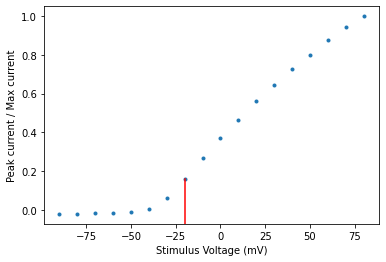

In [17]:
plt.plot(stim_v, max_i, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Peak current / Max current")
plt.plot([act_v, act_v], [ylim[0], act_i], color="red")
plt.ylim(ylim)

We can also show the evolution of the steady state current at the end of the stimulus across input voltage:

Text(0, 0.5, 'Steady State Current (nA)')

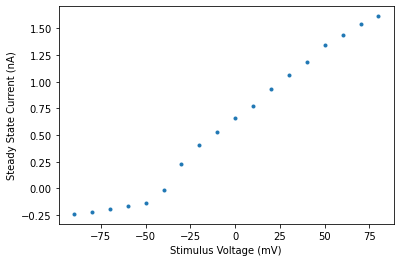

In [18]:
ssis = np.array([feat_dict["steady_state_voltage_stimend"][0] for feat_dict in feats])
plt.plot(stim_v, ssis, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Steady State Current (nA)")

Finally, we can also plot the current base. Since this feature is compute on the trace before the stimulus is applied, it should be constent across the traces.

Text(0, 0.5, 'Current Base (nA)')

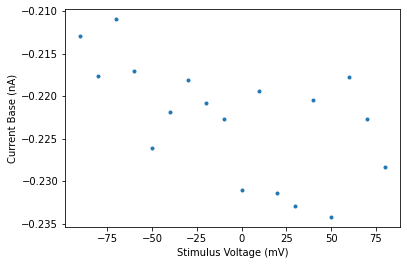

In [19]:
i_base = np.array([feat_dict["voltage_base"][0] for feat_dict in feats])
plt.plot(stim_v, i_base, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Current Base (nA)")